In [4]:
import pandas as pd
import re

In [4]:
# df for single RCT summary stats.

# Load data
cleaned_df = pd.read_csv('cleaned_df_severe_outcome.csv', low_memory=False)

# Define columns
categorical_cols = ['mi', 'acearb', 'diur_any', 'anticoag', 'digoxin', 'severe_outcome','gender', 'nyhac2']
numerical_cols = ['age', 'bmi', 'hr', 'sbp', 'lvef','creat']

# Group by study
grouped = cleaned_df.groupby('study')

# --- Numerical Summary Stats ---
numerical_summary = grouped[numerical_cols].agg(['mean', 'std', 'min', 'max', 'median'])

# Flatten MultiIndex columns
numerical_summary.columns = ['_'.join(col) for col in numerical_summary.columns]
numerical_summary.reset_index(inplace=True)

# --- Categorical Summary Stats (as percentages) ---
categorical_summary_list = []

for study_name, group in grouped:
    cat_stats = {}
    cat_stats['study'] = study_name
    
    for col in categorical_cols:
        value_counts = group[col].value_counts(normalize=True) * 100  # as percentages
        for category, pct in value_counts.items():
            cat_stats[f"{col}_class_{category}"] = pct
    
    categorical_summary_list.append(cat_stats)

categorical_summary = pd.DataFrame(categorical_summary_list)

# --- Merge both summaries ---
summary_stats_by_study = pd.merge(numerical_summary, categorical_summary, on='study', how='outer')

# Replace NaNs with 0
summary_stats_by_study.fillna(0, inplace=True)

# add n_samples
summary_stats_by_study['n_samples'] = summary_stats_by_study['study'].map(
    cleaned_df['study'].value_counts()
)

# Save or display
summary_stats_by_study = summary_stats_by_study.round(2)
#summary_stats_by_study.to_csv('summary_stats_by_study.csv', index=False)
summary_stats_by_study

,study,age_mean,age_std,age_min,age_max,age_median,bmi_mean,bmi_std,bmi_min,bmi_max,...,anticoag_class_1,digoxin_class_0,digoxin_class_1,severe_outcome_class_1,severe_outcome_class_0,gender_class_0,gender_class_1,nyhac2_class_0,nyhac2_class_1,n_samples
0,ANZ,66.43,7.29,42,87,67.0,26.89,4.11,17.31,42.42,...,17.12,62.28,37.72,54.34,45.66,79.65,20.35,83.87,16.13,403
1,BEST,59.79,12.29,25,85,61.0,28.07,5.91,16.27,62.30,...,42.50,7.71,92.29,70.80,29.20,77.73,22.27,0.00,100.00,2555
2,CAPRICORN,62.50,11.47,25,90,64.0,27.22,4.31,15.42,53.45,...,10.40,91.44,8.56,45.66,54.34,73.81,26.19,89.26,10.74,1741
3,CIBIS II,60.68,10.55,22,80,62.0,26.88,4.09,15.78,47.55,...,25.90,48.97,51.03,41.48,58.52,80.47,19.53,0.00,100.00,2483
4,COPERNICUS,62.22,11.36,22,93,63.0,26.98,4.81,15.24,59.57,...,33.13,35.26,64.74,39.53,60.47,79.92,20.08,0.00,100.00,2107
5,MDC,48.57,12.03,16,71,50.0,26.60,4.94,17.72,52.69,...,49.36,24.36,75.64,36.22,63.78,72.76,27.24,48.72,51.28,312
6,MERIT-HF,63.22,9.70,40,81,64.0,27.25,4.65,14.79,51.44,...,37.01,36.24,63.76,35.23,64.77,77.58,22.42,40.95,59.05,3858
7,SENIORS,75.45,4.55,69,94,75.0,26.61,3.96,14.71,50.39,...,24.06,56.21,43.79,43.73,56.27,65.15,34.85,57.53,42.47,1667
8,US Carvedilol,57.68,12.04,18,89,58.0,27.53,5.22,12.41,46.24,...,54.33,10.13,89.87,28.43,71.57,76.24,23.76,53.07,46.93,1027


In [17]:
results_LOSO_all

,Test Study,Train Studies,Num Train Studies,Accuracy,Recall,Precision,F1 Score,ROC AUC,y_test,y_pred,y_proba
0,MDC,"('SENIORS',)",1,0.634615,0.265487,0.491803,0.344828,0.608796,[1 0 0 1 0 0 0 1 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0...,[1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0...,[0.5336275 0.4911104 0.420639 0.49738082 0...
1,MDC,"('US Carvedilol',)",1,0.641026,0.017699,0.666667,0.034483,0.660026,[1 0 0 1 0 0 0 1 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0...,[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[0.39298466 0.21544436 0.39984107 0.21350828 0...
2,MDC,"('ANZ',)",1,0.445513,0.884956,0.384615,0.536193,0.611998,[1 0 0 1 0 0 0 1 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1...,[0.790065 0.643928 0.7109513 0.53779525 0...
3,MDC,"('CIBIS II',)",1,0.602564,0.407080,0.446602,0.425926,0.608485,[1 0 0 1 0 0 0 1 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0...,[0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 0 1 0 0 1 0...,[0.26473507 0.3909046 0.46550733 0.5546213 0...
4,MDC,"('MERIT-HF',)",1,0.660256,0.212389,0.585366,0.311688,0.639080,[1 0 0 1 0 0 0 1 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0...,[0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0...,[0.45230517 0.22181869 0.30014697 0.321607 0...
...,...,...,...,...,...,...,...,...,...,...,...
2290,BEST,"('MDC', 'SENIORS', 'US Carvedilol', 'CIBIS II'...",7,0.459491,0.303483,0.819403,0.442921,0.625257,[1 1 1 ... 1 0 1],[0 0 1 ... 0 0 1],[0.43007147 0.3951416 0.6285916 ... 0.466514...
2291,BEST,"('MDC', 'SENIORS', 'ANZ', 'CIBIS II', 'MERIT-H...",7,0.500978,0.385849,0.809745,0.522651,0.625925,[1 1 1 ... 1 0 1],[0 0 1 ... 1 0 1],[0.44658366 0.40270147 0.6166743 ... 0.500817...
2292,BEST,"('MDC', 'US Carvedilol', 'ANZ', 'CIBIS II', 'M...",7,0.451272,0.280265,0.835255,0.419702,0.624658,[1 1 1 ... 1 0 1],[0 0 1 ... 0 0 1],[0.454924 0.38959795 0.5860636 ... 0.447755...
2293,BEST,"('SENIORS', 'US Carvedilol', 'ANZ', 'CIBIS II'...",7,0.449315,0.283029,0.823151,0.421226,0.619373,[1 1 1 ... 1 0 1],[0 0 1 ... 0 0 1],[0.42121905 0.3993838 0.6031372 ... 0.480501...


In [ ]:
# merging single summary df with true labels of good/bad model

results_LOSO_all = pd.read_csv('results df/results_LOSO_gpu.csv')

LOSO_filtered_df = results_LOSO_all[results_LOSO_all['n_test_studies'] == 1]
LOSO_filtered_df['study'] = LOSO_filtered_df['test_combo'].str.replace(r"[(),'']", '', regex=True)
LOSO_filtered_df = LOSO_filtered_df[['study','roc_auc']]


# clean labels
results_LOSO_all['test_combo_clean'] = results_LOSO_all['test_combo'].apply(
    lambda x: '_'.join(sorted(str(x)
        .replace('(', '')
        .replace(')', '')
        .replace("'", '')
        .replace(',', '')
        .split())))


# merge LOSO_filtered_df with summary_stats_by_study
merged_df_true_labels = pd.merge(LOSO_filtered_df, summary_stats_by_study, on='study', how='inner')

# add label column
merged_df_true_labels['label_degradation'] = (merged_df_true_labels['roc_auc'] < 0.60).astype(int) #0 -> not degraded, 1 -> degraded

In [5]:
# supervised model, single RCTs, with true y_values, no combinations

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler

# Features and target
X = merged_df_true_labels.drop(columns=['study', 'roc_auc', 'label_degradation'])
y = merged_df_true_labels['label_degradation']

# Optional: scale features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train logistic regression
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the full dataset
y_pred_all = model.predict(X_scaled)

# Add to original DataFrame
merged_df_true_labels['predicted_degradation'] = y_pred_all

# Optionally inspect
print(merged_df_true_labels[['study', 'label_degradation', 'predicted_degradation']].head())


#################################################

# unsupervised model, no combinations


# Drop label and prepare data
X_unsupervised = merged_df_true_labels.drop(columns=['study', 'roc_auc', 'label_degradation'])

# Scale features
scaler = RobustScaler()
X_scaled_unsup = scaler.fit_transform(X_unsupervised)

# Apply KMeans clustering (2 clusters)
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled_unsup)

# Add predicted cluster to DataFrame
merged_df_true_labels['unsupervised_cluster'] = cluster_labels

# View comparison
print(merged_df_true_labels[['study', 'unsupervised_cluster']].head())

           study  label_degradation  predicted_degradation
0            MDC                  0                      0
1  US Carvedilol                  0                      0
2       CIBIS II                  0                      0
3        SENIORS                  0                      0
4           BEST                  0                      0
           study  unsupervised_cluster
0            MDC                     1
1  US Carvedilol                     1
2       CIBIS II                     1
3        SENIORS                     0
4           BEST                     1


In [6]:
# Compute summary statistics for all features of all combinations of RCTs, in respect of each RCTs weight: 

import pandas as pd
from itertools import combinations

# Your current summary dataset of individual RCTs with summary stats & n_samples
summary_stats_by_study = summary_stats_by_study.copy()

# List of all studies
studies = summary_stats_by_study['study'].tolist()

# Features columns to aggregate (exclude 'study' and 'n_samples')
feature_cols = [col for col in summary_stats_by_study.columns if col not in ['study', 'n_samples']]

def weighted_average(df, weights_col, feature_cols):
    """Calculate weighted average of feature columns using weights_col."""
    weights = df[weights_col]
    weighted_means = {}
    for col in feature_cols:
        weighted_means[col] = (df[col] * weights).sum() / weights.sum()
    return weighted_means



rows = []

for test_size in range(1, len(studies)):  # 1 to 8 inclusive
    for test_studies in combinations(studies, test_size):
        test_studies = tuple(sorted(test_studies))
        train_studies = [s for s in studies if s not in test_studies]
        

        # Get train and test dataframes
        train_df = summary_stats_by_study[summary_stats_by_study['study'].isin(train_studies)]
        test_df = summary_stats_by_study[summary_stats_by_study['study'].isin(test_studies)]

        # Weighted average of train summary stats
        train_summary = weighted_average(train_df, 'n_samples', feature_cols)
        # Weighted average of test summary stats
        test_summary = weighted_average(test_df, 'n_samples', feature_cols)

        # Total samples in train/test
        n_train = train_df['n_samples'].sum()
        n_test = test_df['n_samples'].sum()

        # Build combined row dictionary
        row = {
            'train_combination': '_'.join(train_studies),
            'test_combination': '_'.join(test_studies),
            'n_train_samples': n_train,
            'n_test_samples': n_test,
        }

        # Add train features prefixed with 'train_'
        for k, v in train_summary.items():
            row[f'train_{k}'] = v

        # Add test features prefixed with 'test_'
        for k, v in test_summary.items():
            row[f'test_{k}'] = v

        rows.append(row)

# Create DataFrame
combo_summary_df = pd.DataFrame(rows)
combo_summary_df = combo_summary_df.round(2)

,train_combination,test_combination,n_train_samples,n_test_samples,train_age_mean,train_age_std,train_age_min,train_age_max,train_age_median,train_bmi_mean,...,test_anticoag_class_0,test_anticoag_class_1,test_digoxin_class_0,test_digoxin_class_1,test_severe_outcome_class_1,test_severe_outcome_class_0,test_gender_class_0,test_gender_class_1,test_nyhac2_class_0,test_nyhac2_class_1
0,BEST_CAPRICORN_CIBIS II_COPERNICUS_MDC_MERIT-H...,ANZ,15750,403,62.69,10.33,31.82,85.79,63.56,27.22,...,82.88,17.12,62.28,37.72,54.34,45.66,79.65,20.35,83.87,16.13
1,ANZ_CAPRICORN_CIBIS II_COPERNICUS_MDC_MERIT-HF...,BEST,13598,2555,63.35,9.87,33.41,85.98,64.14,27.05,...,57.50,42.50,7.71,92.29,70.80,29.20,77.73,22.27,0.00,100.00
2,ANZ_BEST_CIBIS II_COPERNICUS_MDC_MERIT-HF_SENI...,CAPRICORN,14412,1741,62.82,10.10,32.93,85.32,63.60,27.21,...,89.60,10.40,91.44,8.56,45.66,54.34,73.81,26.19,89.26,10.74
3,ANZ_BEST_CAPRICORN_COPERNICUS_MDC_MERIT-HF_SEN...,CIBIS II,13670,2483,63.17,10.20,33.91,86.88,63.94,27.28,...,74.10,25.90,48.97,51.03,41.48,58.52,80.47,19.53,0.00,100.00
4,ANZ_BEST_CAPRICORN_CIBIS II_MDC_MERIT-HF_SENIO...,COPERNICUS,14046,2107,62.87,10.08,33.59,84.74,63.74,27.25,...,66.87,33.13,35.26,64.74,39.53,60.47,79.92,20.08,0.00,100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,COPERNICUS,ANZ_BEST_CAPRICORN_CIBIS II_MDC_MERIT-HF_SENIO...,2107,14046,62.22,11.36,22.00,93.00,63.00,26.98,...,67.82,32.18,41.09,58.91,45.18,54.82,76.03,23.97,36.51,63.49
506,CIBIS II,ANZ_BEST_CAPRICORN_COPERNICUS_MDC_MERIT-HF_SEN...,2483,13670,60.68,10.55,22.00,80.00,62.00,26.88,...,66.53,33.47,38.76,61.24,44.98,55.02,75.82,24.18,37.51,62.49
507,CAPRICORN,ANZ_BEST_CIBIS II_COPERNICUS_MDC_MERIT-HF_SENI...,1741,14412,62.50,11.47,25.00,90.00,64.00,27.22,...,65.05,34.95,34.15,65.85,44.30,55.70,76.87,23.13,24.80,75.20
508,BEST,ANZ_CAPRICORN_CIBIS II_COPERNICUS_MDC_MERIT-HF...,2555,13598,59.79,12.29,25.00,85.00,61.00,28.07,...,69.61,30.39,46.46,53.54,39.49,60.51,76.31,23.69,37.71,62.29


In [21]:
import pandas as pd
import ast

# Step 1: Safely convert tuple strings to actual tuples, then sort and join
def clean_combo_string(combo):
    # Convert string to tuple safely if needed
    if isinstance(combo, str):
        try:
            combo = ast.literal_eval(combo)
        except:
            pass  # fallback in case it's already a clean tuple
    # Ensure it's a list/tuple of strings, strip and uppercase for consistency
    combo = [str(study).strip() for study in combo]
    return '_'.join(sorted(combo))

# Apply to the DataFrame
results_LOSO_all['test_combo_clean'] = results_LOSO_all['test_combo'].apply(clean_combo_string)

# Optional: sort for preview
results_LOSO_all = results_LOSO_all.sort_values('test_combo_clean').reset_index(drop=True)

# Preview
print(results_LOSO_all[['test_combo', 'test_combo_clean']].head())

intersection = set(results_LOSO_all['test_combo']) & set(combo_summary_df['test_combination'])
print(f"Matching combinations: {len(intersection)} out of {len(results_LOSO_all)}")

                                          test_combo  \
0                                           ('ANZ',)   
1                                    ('ANZ', 'BEST')   
2                       ('ANZ', 'CAPRICORN', 'BEST')   
3           ('ANZ', 'CIBIS II', 'CAPRICORN', 'BEST')   
4  ('ANZ', 'CIBIS II', 'COPERNICUS', 'CAPRICORN',...   

                         test_combo_clean  
0                                     ANZ  
1                                ANZ_BEST  
2                      ANZ_BEST_CAPRICORN  
3             ANZ_BEST_CAPRICORN_CIBIS II  
4  ANZ_BEST_CAPRICORN_CIBIS II_COPERNICUS  


In [26]:
# combine roc_auc values with df summary of all combos
results_LOSO_all['test_combination'] = results_LOSO_all['test_combo'] # rename to match

combo_summary_df['roc_auc'] = combo_summary_df['test_combination'].map(
    results_LOSO_all.set_index('test_combination')['roc_auc']
)

# inspect if done correctly
print(combo_summary_df.loc[35])
print(results_LOSO_all[results_LOSO_all['test_combination'] == 'COPERNICUS_MDC'])

In [66]:
# add label column
combo_summary_df['label_degradation'] = (combo_summary_df['roc_auc'] < 0.60).astype(int) 

# save document
combo_summary_df.to_csv('predictive_results_combo_summary_df.csv', index=False)

In [5]:
# read 
combo_summary_df = pd.read_csv('results df/predictive_results_combo_summary_df.csv', low_memory=False)

In [6]:
combo_summary_df['label_degradation'].value_counts()

label_degradation
1    257
0    253
Name: count, dtype: int64

In [7]:
combo_summary_df.columns

Index(['train_combination', 'test_combination', 'n_train_samples',
       'n_test_samples', 'train_age_mean', 'train_age_std', 'train_age_min',
       'train_age_max', 'train_age_median', 'train_bmi_mean', 'train_bmi_std',
       'train_bmi_min', 'train_bmi_max', 'train_bmi_median', 'train_hr_mean',
       'train_hr_std', 'train_hr_min', 'train_hr_max', 'train_hr_median',
       'train_sbp_mean', 'train_sbp_std', 'train_sbp_min', 'train_sbp_max',
       'train_sbp_median', 'train_lvef_mean', 'train_lvef_std',
       'train_lvef_min', 'train_lvef_max', 'train_lvef_median',
       'train_creat_mean', 'train_creat_std', 'train_creat_min',
       'train_creat_max', 'train_creat_median', 'train_mi_class_1',
       'train_mi_class_0', 'train_acearb_class_1', 'train_acearb_class_0',
       'train_diur_any_class_1', 'train_diur_any_class_0',
       'train_anticoag_class_0', 'train_anticoag_class_1',
       'train_digoxin_class_0', 'train_digoxin_class_1',
       'train_severe_outcome_class_1',

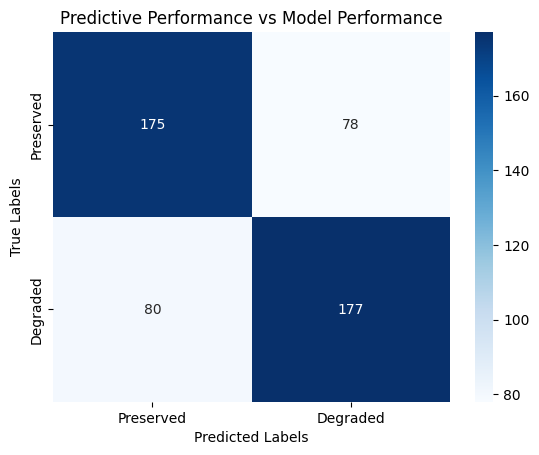

In [80]:
# Now compute confusion matrix (not moodel)
cm = confusion_matrix(combo_summary_df['label_degradation'], combo_summary_df['unsupervised_cluster_labels'])

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['Preserved', 'Degraded'],
            yticklabels=['Preserved', 'Degraded'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Predictive Performance vs Model Performance')
plt.show()

/home/sxa1953/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


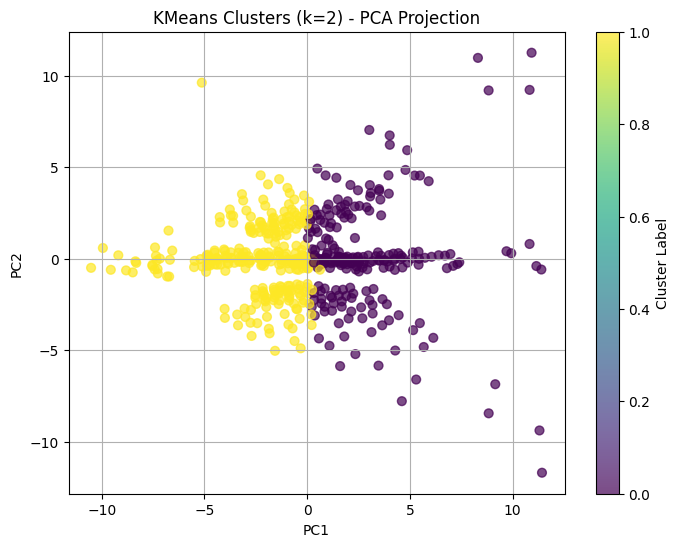

/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


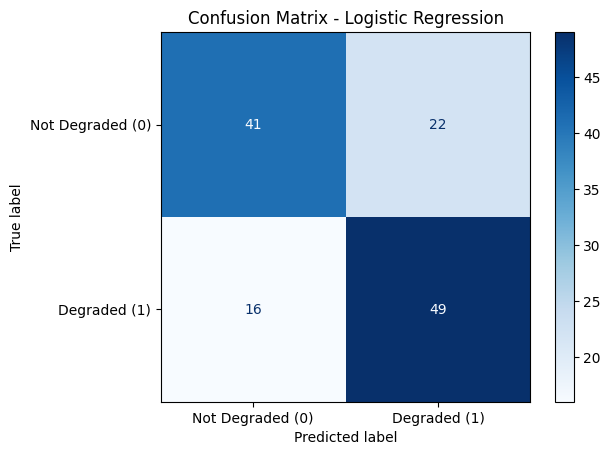

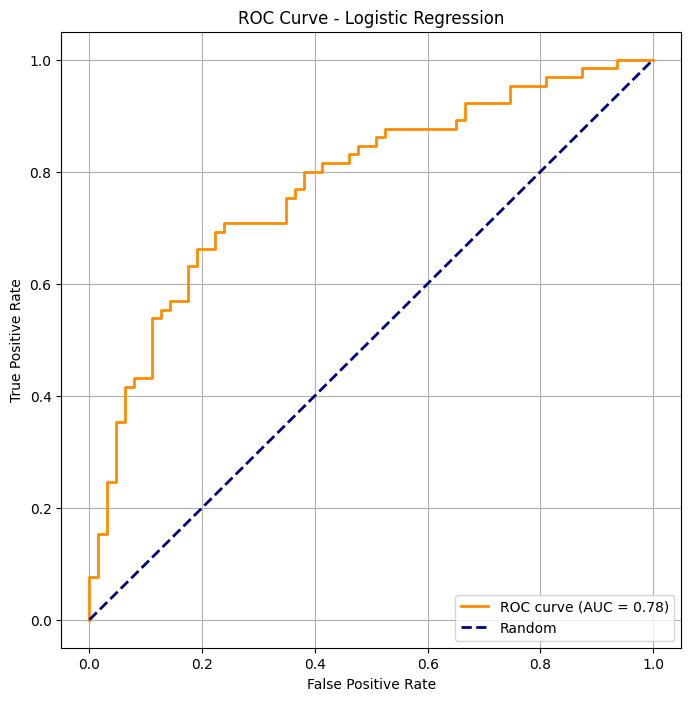

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

# remove TEST columns
combo_summary_df_no_test_info = combo_summary_df_no_test_info = combo_summary_df.loc[
    :, 
    ~combo_summary_df.columns.str.contains('^test_|^n_test_samples$')
]


# define X and Y
X = combo_summary_df_no_test_info.drop(columns=['label_degradation', 'unsupervised_cluster_labels', 
                                   'train_combination', 'roc_auc'])
y = combo_summary_df_no_test_info['label_degradation']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


#################################


# Step 2: Scale features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Step 4: Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add predicted cluster to DataFrame
#combo_summary_df['unsupervised_cluster_labels'] = cluster_labels

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=40, alpha=0.7)
plt.title('KMeans Clusters (k=2) - PCA Projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

#################################

# Model Logistic Regression
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Not Degraded (0)', 'Degraded (1)'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sort data by number of training samples
df_sorted = combo_summary_df_no_test_info.sort_values('n_train_samples')

# Define training sample size points to evaluate
sample_sizes = np.linspace(df_sorted['n_train_samples'].min(), 
                           df_sorted['n_train_samples'].max(), 20)

# Calculate degradation rate for samples <= each sample size (cumulative)
degradation_rates = []
for size in sample_sizes:
    subset = df_sorted[df_sorted['n_train_samples'] <= size]
    rate = subset['roc_auc'].median()
    degradation_rates.append(rate)

# Plot learning curve
plt.figure(figsize=(8,6))
plt.plot(sample_sizes, degradation_rates, marker='o')
plt.xlabel('Training Sample Size')
plt.ylabel('Model performance')
plt.title('Learning Curve: Model Degradation vs Training Sample Size')
plt.grid(True)
plt.show()

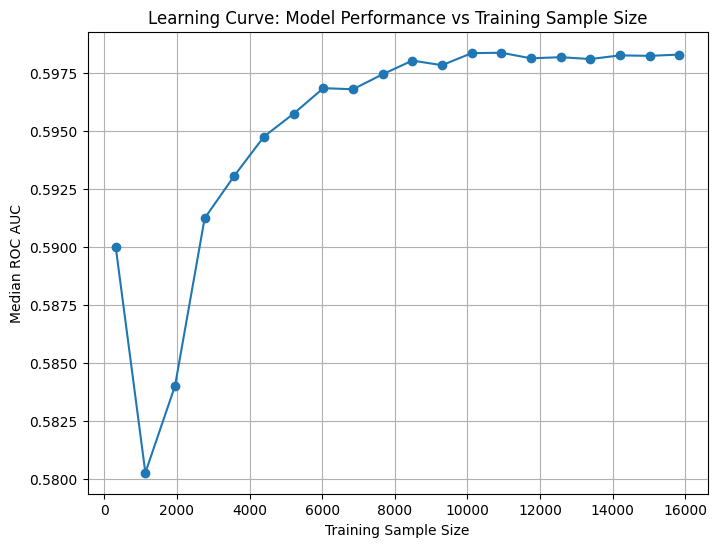

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Sort data by number of training samples
df_sorted = combo_summary_df_no_test_info.sort_values('n_train_samples')

# Define 20 sample size points evenly spaced within the range (integers)
sample_sizes = np.linspace(df_sorted['n_train_samples'].min(), 
                           df_sorted['n_train_samples'].max(), 20).astype(int)

# Calculate median ROC AUC for samples with size <= each sample size (cumulative)
degradation_rates = []
for size in sample_sizes:
    subset = df_sorted[df_sorted['n_train_samples'] <= size]
    if subset.empty:
        degradation_rates.append(np.nan)  # or 0, or skip
    else:
        median_auc = subset['roc_auc'].mean()
        degradation_rates.append(median_auc)

# Remove nan points if any
sample_sizes = sample_sizes[~np.isnan(degradation_rates)]
degradation_rates = np.array(degradation_rates)[~np.isnan(degradation_rates)]

# Plot learning curve
plt.figure(figsize=(8,6))
plt.plot(sample_sizes, degradation_rates, marker='o')
plt.xlabel('Training Sample Size')
plt.ylabel('Median ROC AUC')
plt.title('Learning Curve: Model Performance vs Training Sample Size')
plt.grid(True)
plt.show()


In [2]:
combo_summary_df_no_test_info

NameError: name 'combo_summary_df_no_test_info' is not defined